In [4]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

# Simulation Rules:
- if I have a stock, I sell it, store the return between the sell price and the buy price; then update the history
- fit the ARIMA model
- predict the next return
- if is above a th, I buy

## Plot
- everytime I buy, I store the date
- everytime I sell, I store the date and the return

# Importing Data stocks

In [5]:
tickerSymbol = 'AAPL' ## APPLE stock
data = yf.Ticker(tickerSymbol)

In [87]:
prices = data.history(start='2024-01-01', end='2024-04-01',).Close
returns = prices.pct_change().dropna() # the percentage change between the current and prior element in the prices

In [88]:
prices.head()
prices.index = pd.to_datetime(prices.index)

In [90]:
len(returns)

60

In [91]:
returns.head()

Date
2024-01-03 00:00:00-05:00   -0.007488
2024-01-04 00:00:00-05:00   -0.012700
2024-01-05 00:00:00-05:00   -0.004013
2024-01-08 00:00:00-05:00    0.024175
2024-01-09 00:00:00-05:00   -0.002263
Name: Close, dtype: float64

## Remarks:

- use ACF to estimate the q of MA(q)
- use PACF to estimate the k of AR(k)

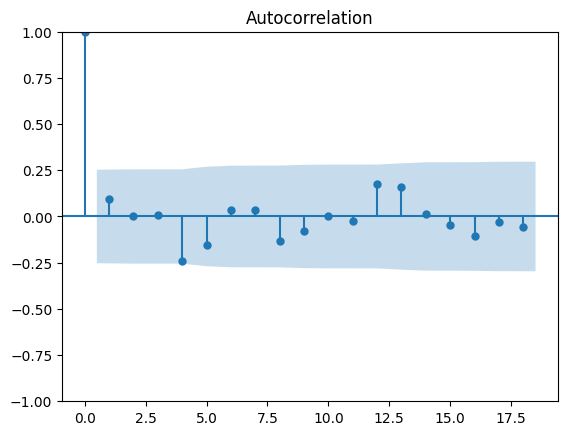

In [92]:
plot_acf(returns)
plt.show()

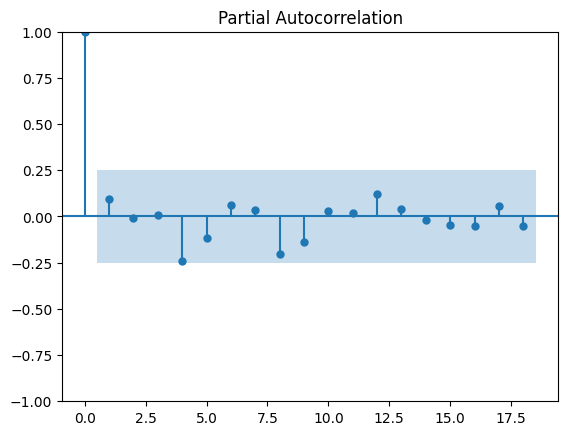

In [93]:
plot_pacf(returns)
plt.show()

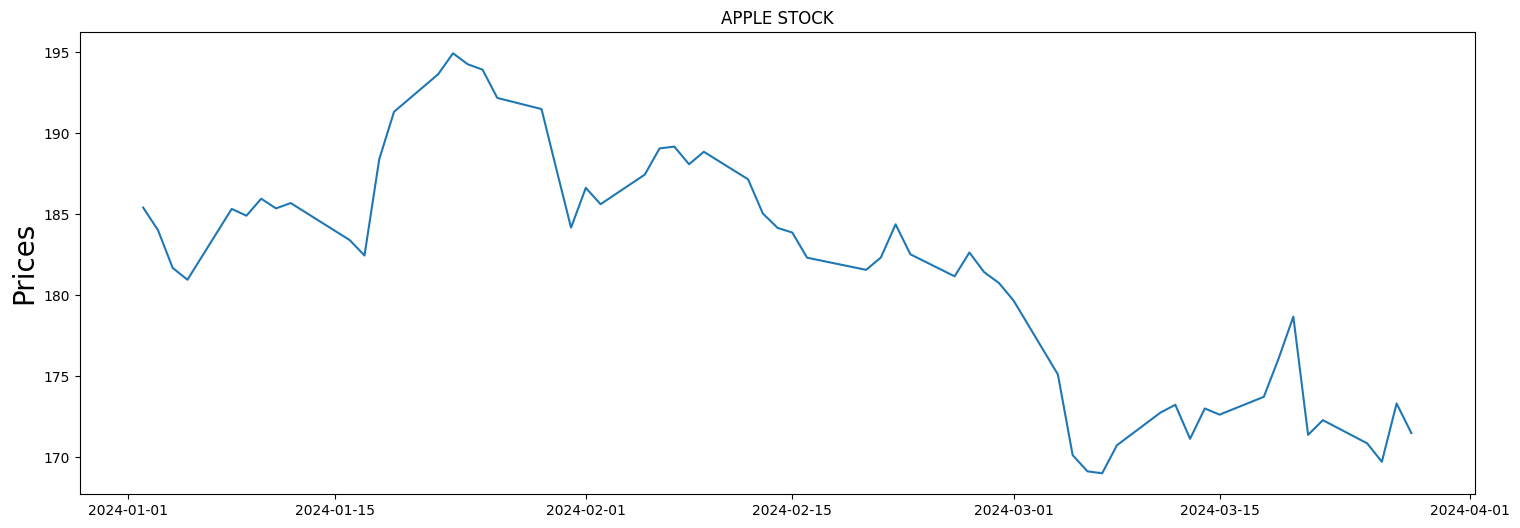

In [94]:
plt.figure(figsize=(18,6))
plt.plot(prices)
plt.title("APPLE STOCK")
plt.ylabel('Prices', fontsize=20)
plt.show()

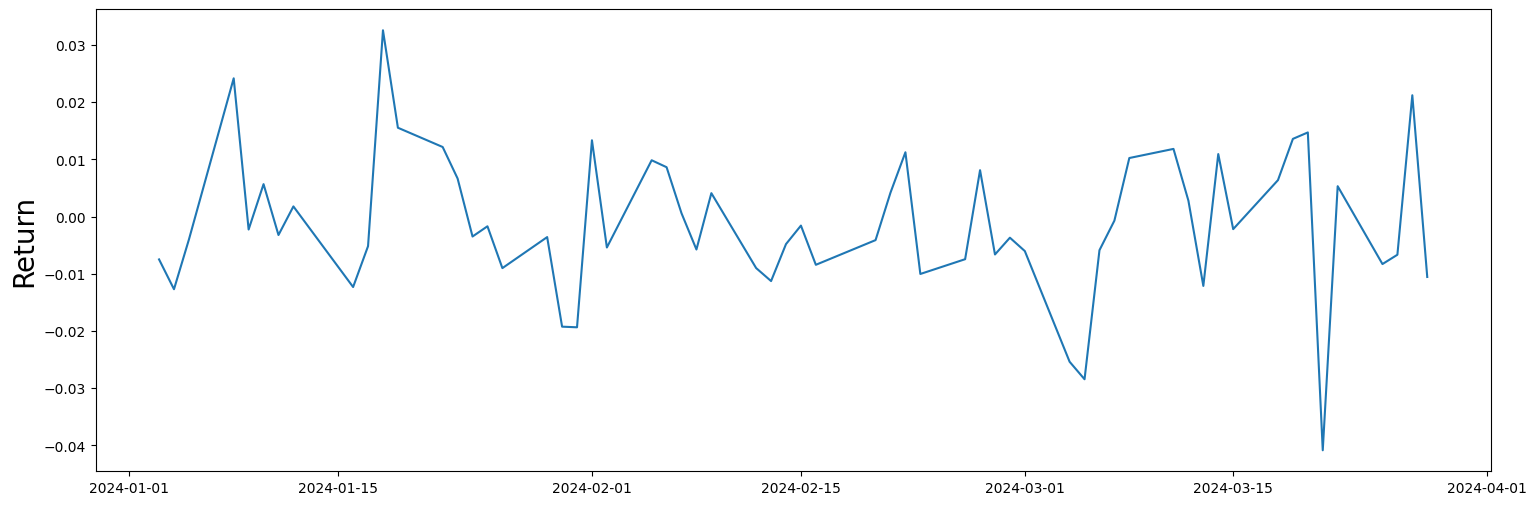

In [95]:
plt.figure(figsize=(18,6))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)
plt.show()

# Run a simulation using the loaded data!

# ARMA Model:
- This assumes the data is stationary; To achieve this we use the returns instead of the actual values!

In [97]:
def run_simulation(returns, prices, amt, order, thresh, plot=True):
    # Store variables
    curr_holding = False
    events_list = []
    init_amt = amt
    buy_price = None
    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret) # update the amount of money i have!
            events_list.append(('s', date, ret)) # store the tuple (date, return)
            
        #get data til just before current date
        curr_data = returns[:date]
        ind+=1
                
        curr_data = curr_data.asfreq(pd.infer_freq(curr_data.index))
        

        # Create a new DataFrame with the converted index
        # Fit ARIMA model using the new DataFrame
        model = ARIMA(curr_data, order=order).fit()

        # predict the next return!
        pred = model.forecast(steps = 1).iloc[0]
    
        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and (pred > thresh): 
            curr_holding = True
            
            buy_price = prices.loc[date]
            events_list.append(('b', date))
        
    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        # If i have a postive return i have a green area, else red area.
        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt


In [98]:
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

100%|██████████| 46/46 [00:01<00:00, 35.63it/s]


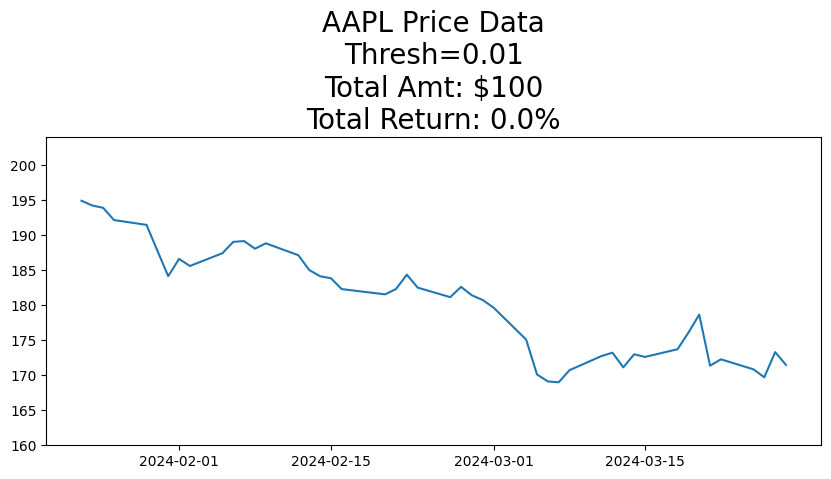

In [99]:
prices.index = pd.to_datetime(prices.index)
s1 = run_simulation(returns, prices, 100, (1,0,1),0.01,True)

In [ ]:
gains = []
th = []
for i in range(0, 101):  # Range from 0 to 100 inclusive
    thresh = i / 100.0 
    s = run_simulation(returns, prices, 100, (1,0,1), thresh, plot=False)
    gains.append(s)
    th.append(thresh)


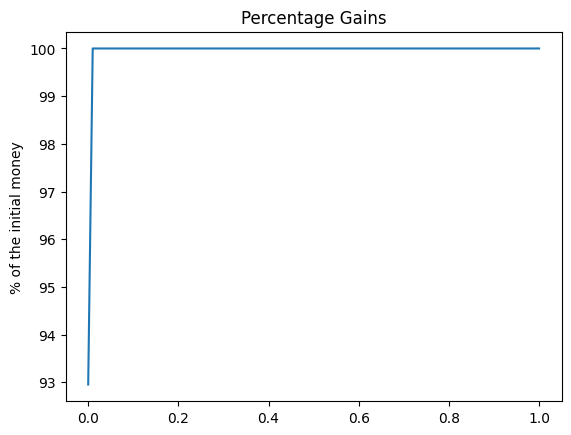

In [118]:
plt.plot(th,gains)
plt.title("Percentage Gains")
plt.ylabel("% of the initial money")
plt.show()

Basically, no loss here if i implemented this approach for almost all the thresholds